In [1]:
from collections import defaultdict
import numpy as np

In [ ]:
qrel_file = f"../msmarco/2019qrels-pass.txt"

qrels = defaultdict(dict)
with open(qrel_file) as f:
    for line in f:
        try:
            qid, _, did, rel = line.strip().split("\t")
        except:
            qid, _, did, rel = line.strip().split(" ")
        if int(rel) > 0:
            qrels[qid][did] = int(rel)
qrel_file = f"../msmarco/2020qrels-pass.txt"
with open(qrel_file) as f:
    for line in f:
        try:
            qid, _, did, rel = line.strip().split("\t")
        except:
            qid, _, did, rel = line.strip().split(" ")
        if int(rel) > 0:
            qrels[qid][did] = int(rel)

In [5]:
multi_queries = []
with open("../msmarco/training_queries/train_queries_distill_splade_colbert_0.json") as f:
    for line in f:
        qid = line.split("\t")[0]
        if qid in qrels and len(qrels[qid]) > 1:
            multi_queries.append(qid)

FileNotFoundError: [Errno 2] No such file or directory: '../msmarco/training_queries/train_queries_distill_splade_colbert_0.json'

In [6]:
import tqdm
import json
train_query_file = "../msmarco/training_queries/train_queries_distill_splade_colbert_0.json"
#train_queries_good = dict()
train_queries = dict()

with open(train_query_file) as f: #training_queries_splade_max_156000_ceclean.json
    for line in tqdm.tqdm(f):
        qid = line.split("\t")[0]
        if qid in multi_queries:
            train_queries[qid] = json.loads(line.split("\t")[1])

            train_queries[qid]['neg'] = [x for x in train_queries[qid]['neg'] if x[0] <= 20]
            if len(train_queries[line.split("\t")[0]]['neg']) == 0:
                del train_queries[line.split("\t")[0]]
                continue


FileNotFoundError: [Errno 2] No such file or directory: '../msmarco/training_queries/train_queries_distill_splade_colbert_0.json'

In [3]:
#FROM Sentence-BERT(https://github.com/UKPLab/sentence-transformers/blob/afee883a17ab039120783fd0cffe09ea979233cf/examples/training/ms_marco/train_bi-encoder_margin-mse.py) with minimal changes.
#Original License Apache2, NOTE: Trained MSMARCO models are NonCommercial (from dataset License)

import sys
import json
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, LoggingHandler, util, evaluation, InputExample
from training_with_sentence_transformers.sbert import SentenceTransformerA
import training_with_sentence_transformers.models as models
import logging
from datetime import datetime
import gzip
import os
import tarfile
import tqdm
from torch.utils.data import Dataset
import random
from shutil import copyfile
import pickle
import argparse
import  training_with_sentence_transformers.losses as losses
import torch
from collections import defaultdict
from training_with_sentence_transformers.data import MSMARCODataset

import transformers
#from colbert_model import DETeacher


data_folder = '../msmarco'

#### Read the corpus file containing all the passages. Store them in the corpus dict
corpus = {}  # dict in the format: passage_id -> passage. Stores all existing passages
collection_filepath = os.path.join(data_folder, 'collection.tsv')


with open(collection_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        pid, passage = line.strip().split("\t")
        pid = int(pid)
        corpus[pid] = passage

### Read the train queries, store in queries dict

queries = {}  # dict in the format: query_id -> query. Stores all training queries
queries_filepath = os.path.join(data_folder, 'queries.train.tsv')

with open(queries_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        qid, query = line.strip().split("\t")
        qid = int(qid)
        queries[qid] = query

        
ce_scores_file = os.path.join(data_folder, 'cross-encoder-ms-marco-MiniLM-L-6-v2-scores.pkl.gz')

with gzip.open(ce_scores_file, 'rb') as fIn:
    ce_scores = pickle.load(fIn)

KeyboardInterrupt: 

In [ ]:
model_name = "output/colbert_splade_distill_num1_kldiv_multipos_focal_default_alpha0.2_denoiseFalse_num20_kldiv_multipos_focal5-lr1e-05-batch_size_8x4-2022-11-09/10000/0_ColBERTTransformer"
#model_name = "output/colbert_splade_distill_num1_kldiv_multipos_default_alpha0.2_denoiseFalse_num20_kldiv_multipos5-lr1e-05-batch_size_8x4-2022-11-09/10000/0_ColBERTTransformer"


word_embedding_model = models.ColBERTTransformer(model_name, max_seq_length=256)
checkpoint = torch.load(os.path.join(model_name, "checkpoint.pt"), map_location='cpu')
word_embedding_model.load_state_dict(checkpoint)
word_embedding_model.to('cuda')
model = SentenceTransformerA(modules=[word_embedding_model])


In [ ]:
# For training the SentenceTransformer model, we need a dataset, a dataloader, and a loss used for training.
train_dataset = MSMARCODataset(queries=train_queries, corpus=corpus, ce_scores=ce_scores, loss_type="kldiv_focal", num_neg=5, topk = 20)
train_dataloader = DataLoader(train_dataset, shuffle=False, batch_size=4, drop_last=False)
train_dataloader.collate_fn = model.smart_batching_collate
data_iterator = iter(train_dataloader)

In [22]:
with open("../msmarco/train_multipos_data.tsv", "w") as f:
    for qid in train_queries:
        dids = set([info[1] for info in train_queries[qid]['pos']] + [info[1] for info in train_queries[qid]['neg']])
        for did in dids:
            f.write(f"{qid}\t{did}\t{query}\t{corpus[did]}\n")


# read data and compute cross entropy

In [1]:
from scipy.stats import entropy
from collections import defaultdict
from scipy.special import softmax
import numpy as np
def gen_cross_entropy(scores):
    return entropy(softmax(scores), base=2)

def gen_p(pos_scores, scores):
    return sum([np.exp(x) for x in pos_scores]) / sum([np.exp(x) for x in scores])


def gen_min_max(pos_scores, scores):
    neg_scores = [x for x in scores if x not in pos_scores]
    all = sum([np.exp(x) for x in scores])
    return min([np.exp(x) for x in pos_scores]) / all,  max([np.exp(x) for x in neg_scores]) / all

def gen_median(pos_scores, scores):
    neg_scores = [x for x in scores if x not in pos_scores]
    all = sum([np.exp(x) for x in scores])
    return np.median([np.exp(x) for x in pos_scores]) / all,  np.median([np.exp(x) for x in neg_scores]) / all

def gen_mean(pos_scores, scores):
    neg_scores = [x for x in scores if x not in pos_scores]
    all = sum([np.exp(x) for x in scores])
    return np.mean([np.exp(x) for x in pos_scores]) / all,  np.mean([np.exp(x) for x in neg_scores]) / all

def gen_max(pos_scores, scores):
    neg_scores = [x for x in scores if x not in pos_scores]
    all = sum([np.exp(x) for x in scores])
    return np.min([np.exp(x) for x in pos_scores]) / all,  np.mean([np.exp(x) for x in neg_scores]) / all

In [2]:
qrel_file = f"../msmarco/qrels.train.tsv"

qrels = defaultdict(dict)
with open(qrel_file) as f:
    for line in f:
        try:
            qid, _, did, rel = line.strip().split("\t")
        except:
            qid, _, did, rel = line.strip().split(" ")
        if int(rel) > 0:
            qrels[qid][did] = int(rel)

In [ ]:

top_k = 20
ce_scores = []
gaps = []
for n in range(1000, 101000, 1000):
    run = defaultdict(dict)
    with open(f"../splade_cls_backup/all_tar/splade_cls/qualitative/output_train_multipos_colbert_kldiv_iter{n}.tsv") as f:
        for line in f:
            qid,did,score = line.strip().split("\t")
            run[qid][did] = float(score)

    entropies = []
    gap_pos_neg = []
    for qid in run:
        pscores = []
        scores = []
        docs = sorted(run[qid].items(), key=lambda x: -x[1])
        for item in docs[:top_k]:
            if item[0] in qrels[qid]:
                pscores.append(item[1])
            scores.append(item[1])
        if len(pscores) == 0 or len(pscores) == len(scores):
            continue
        entropies.append(gen_cross_entropy(pscores))
        minp, maxn = gen_max(pscores, scores)
        gap_pos_neg.append(minp - maxn)
    ce_scores.append(np.mean(entropies))
    gaps.append(np.mean(gap_pos_neg))

In [ ]:

top_k = 20
ce_scores_klfr = []
gaps_klfr = []
for n in range(1000, 101000, 1000):
    run = defaultdict(dict)
    with open(f"../splade_cls_backup/all_tar/splade_cls/qualitative/output_train_multipos_colbert_klfr-gamma5.0_iter{n}.tsv") as f:
        for line in f:
            qid,did,score = line.strip().split("\t")
            run[qid][did] = float(score)

    entropies = []
    gap_pos_neg = []
    for qid in run:
        pscores = []
        scores = []
        docs = sorted(run[qid].items(), key=lambda x: -x[1])
        for item in docs[:top_k]:
            if item[0] in qrels[qid]:
                pscores.append(item[1])
            scores.append(item[1])
        if len(pscores) == 0 or len(pscores) == len(scores):
            continue
        ce = gen_cross_entropy(pscores)
        entropies.append(ce)
        minp, maxn = gen_max(pscores, scores)
        gap_pos_neg.append(minp - maxn)
    
    gaps_klfr.append(np.mean(gap_pos_neg))
    ce_scores_klfr.append(np.mean(entropies))

In [ ]:
qrel_file = f"../msmarco/trec_qrels.txt"

qrels = defaultdict(dict)
with open(qrel_file) as f:
    for line in f:
        try:
            qid, _, did, rel = line.strip().split("\t")
        except:
            qid, _, did, rel = line.strip().split(" ")
        if int(rel) > 0:
            qrels[qid][did] = int(rel)

In [ ]:

top_k = 10
ce_scores_test = []
gaps_test = []
for n in range(1000, 101000, 1000):
    run = defaultdict(dict)
    with open(f"../splade_cls_backup/all_tar/splade_cls/qualitative/output_trec_rel1_multipos_colbert_kldiv_iter{n}.tsv") as f:
    #with open(f"qualitative/output_trec_rel1_multipos_colbert_kldiv_iter{n}.tsv") as f:
        for line in f:
            qid,did,score = line.strip().split("\t")
            run[qid][did] = float(score)

    run_neg = defaultdict(dict)
    with open(f"qualitative/output_trec_rel0_multipos_colbert_kldiv_iter{n}.tsv") as f:
        for line in f:
            qid,did,score = line.strip().split("\t")
            run_neg[qid][did] = float(score)
    

    entropies = []
    gap_pos_neg = []
    for qid in run:
        pscores = []
        scores = []
        docs = sorted(run[qid].items(), key=lambda x: -x[1])
        
        for item in docs[:top_k]:
            if item[0] in qrels[qid]:
                pscores.append(item[1])
                scores.append(item[1])

        if len(pscores) == 0:
            continue

        for did in run_neg[qid]:
            scores.append(run_neg[qid][did])

        if len(pscores) == len(scores):
            continue

        ce = gen_cross_entropy(pscores)
        entropies.append(ce)
        minp, maxn = gen_max(pscores, scores)
        gap_pos_neg.append(minp - maxn)

    ce_scores_test.append(np.mean(entropies))
    gaps_test.append(np.mean(gap_pos_neg))

In [ ]:

top_k = 10
ce_scores_test_klfr = []
gaps_test_klfr = []
for n in range(1000, 101000, 1000):
    run = defaultdict(dict)
    with open(f"../splade_cls_backup/all_tar/splade_cls/qualitative/output_trec_rel1_multipos_colbert_klfr_iter{n}.tsv") as f:
        for line in f:
            qid,did,score = line.strip().split("\t")
            run[qid][did] = float(score)

    run_neg = defaultdict(dict)
    with open(f"qualitative/output_trec_rel0_multipos_colbert_klfr_iter{n}.tsv") as f:
        for line in f:
            qid,did,score = line.strip().split("\t")
            run_neg[qid][did] = float(score)
    

    entropies = []
    gap_pos_neg = []
    for qid in run:
        pscores = []
        scores = []
        docs = sorted(run[qid].items(), key=lambda x: -x[1])
        
        for item in docs[:top_k]:
            if item[0] in qrels[qid]:
                pscores.append(item[1])
                scores.append(item[1])

        if len(pscores) == 0:
            continue

        for did in run_neg[qid]:
            scores.append(run_neg[qid][did])

        if len(pscores) == len(scores):
            continue

        ce = gen_cross_entropy(pscores)
        entropies.append(ce)
        minp, maxn = gen_max(pscores, scores)
        gap_pos_neg.append(minp - maxn)

    ce_scores_test_klfr.append(np.mean(entropies))
    gaps_test_klfr.append(np.mean(gap_pos_neg))

### Check convergence

In [ ]:
import pandas as pd
loss_kl=pd.read_csv("training_with_sentence_transformers/output_ckl/colbert_splade_distill_num1_kldiv_default_alpha0.2_denoiseFalse_num20_kldiv5-lr1e-05-batch_size_8x4-2022-11-25/train_losses.csv", names=["row", "iter", "loss"])
loss_sh=pd.read_csv("training_with_sentence_transformers/output/colbert_splade_distill_num1_kldiv_focal_default_gamma5.0-alpha0.2_denoiseFalse_num20_kldiv_focal5-lr1e-05-batch_size_8x4-2022-12-13/train_losses.csv", names=["row", "iter", "loss"])
window=10
loss_kl_ma = loss_kl.rolling(window).median().dropna()
loss_sh_ma = loss_sh.rolling(window).median().dropna()
x_sh=loss_sh_ma.iter
x_kl=loss_kl_ma.iter
interval = 30

In [ ]:
import pandas as pd
import numpy as np

loss_kl_file = "/expanse/lustre/projects/csb176/yryang/splade_cls/training_with_sentence_transformers/output/colbert_print_loss_kldiv_default_alpha0.2_denoiseFalse_num20_kldiv5-lr1e-05-batch_size_8x4-2023-01-12/train_losses.csv"
loss_sh_file = "/expanse/lustre/projects/csb176/yryang/splade_cls/training_with_sentence_transformers/output/colbert_print_loss_kldiv_focal_default_alpha0.2_denoiseFalse_num20_kldiv_focal5-lr1e-05-batch_size_8x4-2023-01-12/train_losses.csv"


kl_ratio = []
with open(loss_kl_file) as f:
    for line in f:
        _, _, loss, neg, pos = line.strip().split(",")
        kl_ratio.append(np.abs(float(neg) / float(pos)))
        

sh_ratio = []
with open(loss_sh_file) as f:
    for line in f:
        _, _, loss, neg, pos = line.strip().split(",")
        sh_ratio.append(np.abs(float(neg) / float(pos)))
        

In [ ]:
# data
from functools import partial
import pandas as pd 
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

labelsize = 16
plt.style.use('default')
fig, axes = plt.subplots(ncols=5, figsize=(22,3))


colors = ["#1D7790","#CF7543"]
linestyles = ["-", "-", "-", "-"]
linewidth = 2
rlim = 80
x = np.linspace(1000, 1000 + rlim * 1000, rlim)

#axes[0].plot(x_sh[::interval], loss_sh_ma.loss[::interval], color = colors[0], linestyle = linestyles[1], linewidth = linewidth, label = 'sh', zorder=1)
#ax2 = axes[0].twinx()
#ax2.plot(x_kl[:loss_sh_ma.shape[0]:interval], loss_kl_ma.loss[:loss_sh_ma.shape[0]:interval], color = colors[1], linestyle = linestyles[1], linewidth = linewidth, label = 'kldiv', zorder=1)

#axes[0].set_title("Training Loss", fontsize = 16, fontname = 'serif', fontweight="bold")
dataSet = [sh_ratio[:100], kl_ratio[:100]]  
bp = axes[0].boxplot(dataSet, patch_artist = True, notch='True', vert = 0)  
#colors = ["limegreen", "darkorange"]  
for patch, color in zip(bp['boxes'], colors):  
    patch.set_facecolor(color)  
for whisker in bp['whiskers']:  
    whisker.set(color ='black',linewidth = 1.4,linestyle =":")  
for cap in bp['caps']:  
    cap.set(color ='black',linewidth = 2.1)  
for median in bp['medians']:  
    median.set(color ='black',linewidth = 3)  
for flier in bp['fliers']:  
    flier.set(marker ='D',color ='black',alpha = 0.6)   
axes[0].set_yticklabels(['CKL', 'KLDiv'])  
#plt.title("Customized box plot using attributes")  
#ax.get_xaxis().tick_bottom()  
#ax.get_yaxis().tick_left()
#ax.set_facecolor("white")
axes[0].set_xscale('log')
axes[0].axis('on')
axes[0].set_title(r"Neg/Pos Loss Contribution", fontsize = 16, fontname = 'serif', fontweight="bold")

axes[1].plot(x, ce_scores[:rlim], color = colors[1], linestyle = linestyles[1], linewidth = linewidth, label = 'kldiv', zorder=1)
axes[1].plot(x, ce_scores_klfr[:rlim], color = colors[0], linestyle = linestyles[2], linewidth = linewidth, label = 'SH', zorder=1)
axes[1].set_title(r"Doc$^+$ Entropy - Train", fontsize = 16, fontname = 'serif', fontweight="bold")


axes[2].plot(x, ce_scores_test[:rlim], color = colors[1], linestyle = linestyles[1], linewidth = linewidth, label = 'kldiv', zorder=1)
axes[2].plot(x, ce_scores_test_klfr[:rlim], color = colors[0], linestyle = linestyles[2], linewidth = linewidth, label = 'SH', zorder=1)
axes[2].set_title(r"Doc$^+$ Entropy - Test", fontsize = 16, fontname = 'serif', fontweight="bold")


axes[3].plot(x, gaps[:rlim], color = colors[1], linestyle = linestyles[1], linewidth = linewidth, label = 'kldiv', zorder=1)
axes[3].plot(x, gaps_klfr[:rlim], color = colors[0], linestyle = linestyles[2], linewidth = linewidth,  label = 'SH', zorder=1)
axes[3].set_title("Boundary Gap - Train", fontsize = 16, fontname = 'serif', fontweight="bold")


axes[4].plot(x, gaps_test[:rlim], color = colors[1], linestyle = linestyles[1], linewidth = linewidth, label = 'kldiv', zorder=1)
axes[4].plot(x, gaps_test_klfr[:rlim], color = colors[0], linestyle = linestyles[2], linewidth = linewidth, label = 'SH', zorder=1)
axes[4].set_title("Boundary Gap - Test", fontsize = 16, fontname = 'serif', fontweight="bold")


'''
for i in range(0,5):
    axes[i].set_facecolor("white")
    #axes[i].spines['bottom'].set_color('black')
    #axes[i].spines['top'].set_color('black')
    #axes[i].spines['left'].set_color('black')
    #axes[i].spines['right'].set_color('black')
'''

handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in colors]

legend = fig.legend(handles, [r'CKL', r'KLDiv'], loc=[0.5, 0.25], ncol=1, fontsize=15,facecolor='white', framealpha=0.1)

name_font = 14
axes[1].set_ylabel("Entropy", fontsize=name_font, fontweight="bold")
axes[2].set_ylabel("Entropy", fontsize=name_font, fontweight="bold")
axes[3].set_ylabel("Min(Pos) - Max(Neg)", fontsize=name_font, fontweight="bold")
axes[4].set_ylabel("Min(Pos) - Max(Neg)", fontsize=name_font, fontweight="bold")
axes[0].set_ylabel("CKL Loss", fontsize=name_font, fontweight="bold")
#ax2.set_ylabel("KLDiv Loss", fontsize=name_font, fontweight="bold")
#axes[5].set_ylabel("Loss", fontsize=name_font, fontweight="bold")

axes[1].set_xlabel("Iterations", fontsize=name_font, fontweight="bold")
axes[2].set_xlabel("Iterations", fontsize=name_font, fontweight="bold")
axes[3].set_xlabel("Iterations", fontsize=name_font, fontweight="bold")
axes[4].set_xlabel("Iterations", fontsize=name_font, fontweight="bold")
axes[0].set_xlabel("Ratio", fontsize=name_font, fontweight="bold")



for i in range(1,5):
    axes[i].set_xticks([0, 20000, 40000, 60000, 80000], fontsize=10)
    axes[i].tick_params(axis='y', labelsize=6)

axes[0].tick_params(axis='y', labelsize=6)
#ax2.tick_params(axis='y', labelsize=6)

#plt.grid(b=None)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
 
#plt.savefig('prop.pdf',dpi=300,  bbox_inches='tight')
plt.show()


In [29]:
import numpy as np
np.median(sh_ratio), np.median(kl_ratio)

(0.46202534947028984, 4.675405630492913)

/tmp/ipykernel_1653380/2100812842.py:23: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax2.plot(x_kl[:loss_sh_ma.shape[0]:interval], loss_kl_ma.loss[:loss_sh_ma.shape[0]:interval], color = colors[1], linestyle = linestyles[1], linewidth = linewidth, label = 'kldiv', zorder=1)


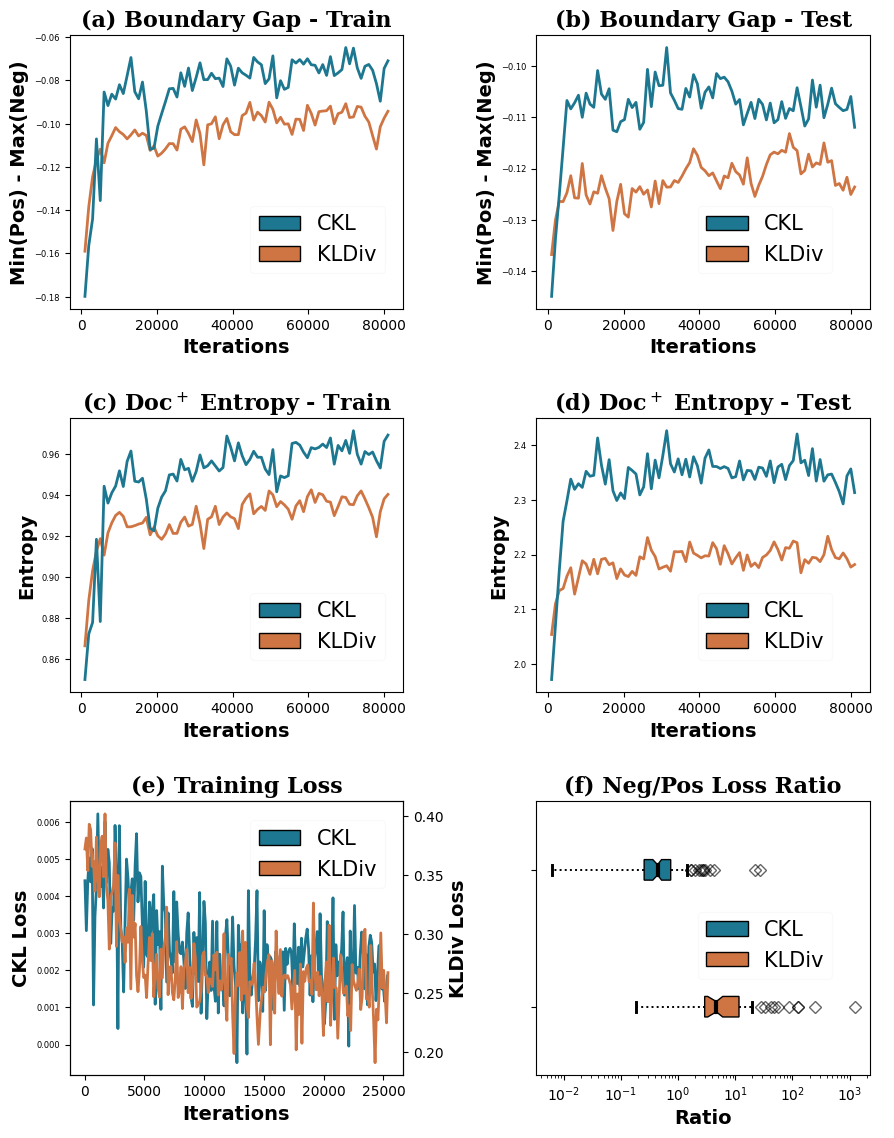

In [28]:
# data
from functools import partial
import pandas as pd 
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

labelsize = 16
plt.style.use('default')
fig, axes = plt.subplots(ncols=2, nrows = 3, figsize=(10,13))


colors = ["#1D7790","#CF7543"]
linestyles = ["-", "-", "-", "-"]
linewidth = 2
rlim = 80
x = np.linspace(1000, 1000 + rlim * 1000, rlim)

axes[2][0].plot(x_sh[::interval], loss_sh_ma.loss[::interval], color = colors[0], linestyle = linestyles[1], linewidth = linewidth, label = 'sh', zorder=1)
ax2 = axes[2][0].twinx()
ax2.plot(x_kl[:loss_sh_ma.shape[0]:interval], loss_kl_ma.loss[:loss_sh_ma.shape[0]:interval], color = colors[1], linestyle = linestyles[1], linewidth = linewidth, label = 'kldiv', zorder=1)

axes[2][0].set_title("(e) Training Loss", fontsize = 16, fontname = 'serif', fontweight="bold")
dataSet = [kl_ratio[:100], sh_ratio[:100]]  
bp = axes[2][1].boxplot(dataSet, patch_artist = True, notch='True', vert = 0)  

for patch, color in zip(bp['boxes'], colors[::-1]):  
    patch.set_facecolor(color)  
for whisker in bp['whiskers']:  
    whisker.set(color ='black',linewidth = 1.4,linestyle =":")  
for cap in bp['caps']:  
    cap.set(color ='black',linewidth = 2.1)  
for median in bp['medians']:  
    median.set(color ='black',linewidth = 3)  
for flier in bp['fliers']:  
    flier.set(marker ='D',color ='black',alpha = 0.6)   
axes[2][1].set_yticklabels(['', '']) 

axes[2][1].set_xscale('log')
axes[2][1].axis('on')
axes[2][1].set_title(r"(f) Neg/Pos Loss Ratio", fontsize = 16, fontname = 'serif', fontweight="bold")

axes[1][0].plot(x, ce_scores[:rlim], color = colors[1], linestyle = linestyles[1], linewidth = linewidth, label = 'kldiv', zorder=1)
axes[1][0].plot(x, ce_scores_klfr[:rlim], color = colors[0], linestyle = linestyles[2], linewidth = linewidth, label = 'SH', zorder=1)
axes[1][0].set_title(r"(c) Doc$^+$ Entropy - Train", fontsize = 16, fontname = 'serif', fontweight="bold")


axes[1][1].plot(x, ce_scores_test[:rlim], color = colors[1], linestyle = linestyles[1], linewidth = linewidth, label = 'kldiv', zorder=1)
axes[1][1].plot(x, ce_scores_test_klfr[:rlim], color = colors[0], linestyle = linestyles[2], linewidth = linewidth, label = 'SH', zorder=1)
axes[1][1].set_title(r"(d) Doc$^+$ Entropy - Test", fontsize = 16, fontname = 'serif', fontweight="bold")


axes[0][0].plot(x, gaps[:rlim], color = colors[1], linestyle = linestyles[1], linewidth = linewidth, label = 'kldiv', zorder=1)
axes[0][0].plot(x, gaps_klfr[:rlim], color = colors[0], linestyle = linestyles[2], linewidth = linewidth,  label = 'SH', zorder=1)
axes[0][0].set_title("(a) Boundary Gap - Train", fontsize = 16, fontname = 'serif', fontweight="bold")


axes[0][1].plot(x, gaps_test[:rlim], color = colors[1], linestyle = linestyles[1], linewidth = linewidth, label = 'kldiv', zorder=1)
axes[0][1].plot(x, gaps_test_klfr[:rlim], color = colors[0], linestyle = linestyles[2], linewidth = linewidth, label = 'SH', zorder=1)
axes[0][1].set_title("(b) Boundary Gap - Test", fontsize = 16, fontname = 'serif', fontweight="bold")


'''
for i in range(0,5):
    axes[i].set_facecolor("white")
    #axes[i].spines['bottom'].set_color('black')
    #axes[i].spines['top'].set_color('black')
    #axes[i].spines['left'].set_color('black')
    #axes[i].spines['right'].set_color('black')
'''

handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in colors]

legend = fig.legend(handles, [r'CKL', r'KLDiv'], loc=[0.28, 0.42], ncol=1, fontsize=15,facecolor='white', framealpha=0.1)
legend = fig.legend(handles, [r'CKL', r'KLDiv'], loc=[0.78, 0.42], ncol=1, fontsize=15,facecolor='white', framealpha=0.1)
legend = fig.legend(handles, [r'CKL', r'KLDiv'], loc=[0.28, 0.76], ncol=1, fontsize=15,facecolor='white', framealpha=0.1)
legend = fig.legend(handles, [r'CKL', r'KLDiv'], loc=[0.78, 0.76], ncol=1, fontsize=15,facecolor='white', framealpha=0.1)

legend = fig.legend(handles, [r'CKL', r'KLDiv'], loc=[0.28, 0.22], ncol=1, fontsize=15,facecolor='white', framealpha=0.1)
legend = fig.legend(handles, [r'CKL', r'KLDiv'], loc=[0.78, 0.14], ncol=1, fontsize=15,facecolor='white', framealpha=0.1)



name_font = 14
axes[1][0].set_ylabel("Entropy", fontsize=name_font, fontweight="bold")
axes[1][1].set_ylabel("Entropy", fontsize=name_font, fontweight="bold")
axes[0][0].set_ylabel("Min(Pos) - Max(Neg)", fontsize=name_font, fontweight="bold")
axes[0][1].set_ylabel("Min(Pos) - Max(Neg)", fontsize=name_font, fontweight="bold")
axes[2][0].set_ylabel("CKL Loss", fontsize=name_font, fontweight="bold")
ax2.set_ylabel("KLDiv Loss", fontsize=name_font, fontweight="bold")
#axes[1].set_ylabel("Loss", fontsize=name_font, fontweight="bold")

axes[1][0].set_xlabel("Iterations", fontsize=name_font, fontweight="bold")
axes[1][1].set_xlabel("Iterations", fontsize=name_font, fontweight="bold")
axes[0][0].set_xlabel("Iterations", fontsize=name_font, fontweight="bold")
axes[0][1].set_xlabel("Iterations", fontsize=name_font, fontweight="bold")
axes[2][0].set_xlabel("Iterations", fontsize=name_font, fontweight="bold")
axes[2][1].set_xlabel("Ratio", fontsize=name_font, fontweight="bold")




axes[1][0].set_xticks([0, 20000, 40000, 60000, 80000], fontsize=10)
axes[1][0].tick_params(axis='y', labelsize=6)
axes[1][1].set_xticks([0, 20000, 40000, 60000, 80000], fontsize=10)
axes[1][1].tick_params(axis='y', labelsize=6)
axes[0][0].set_xticks([0, 20000, 40000, 60000, 80000], fontsize=10)
axes[0][0].tick_params(axis='y', labelsize=6)
axes[0][1].set_xticks([0, 20000, 40000, 60000, 80000], fontsize=10)
axes[0][1].tick_params(axis='y', labelsize=6)

axes[2][0].tick_params(axis='y', labelsize=6)
#ax2.tick_params(axis='y', labelsize=6)

#plt.grid(b=None)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
 
plt.savefig('prop.pdf',dpi=300,  bbox_inches='tight')
plt.show()


# Motivation Check weight 

In [10]:
from collections import defaultdict
qrel_file = f"../msmarco/2019qrels-pass.txt"

qrels = defaultdict(dict)
with open(qrel_file) as f:
    for line in f:
        try:
            qid, _, did, rel = line.strip().split("\t")
        except:
            qid, _, did, rel = line.strip().split(" ")
        if int(rel) > 0:
            qrels[qid][did] = int(rel)

In [24]:

ce_scores_klfr = []
gaps_klfr = []

run = defaultdict(dict)
with open(f"output_2019_colbert-klfr5-1.5_splade-klfr-5-1.0_%remove.tsv") as f:
    for line in f:
        qid,did,score = line.strip().split("\t")
        if did not in qrels[qid] or qrels[qid][did] < 2:
            run[qid][did] = float(score)


In [30]:
qid = '915593'
docs = [x for x in run[qid].items()]
from scipy.special import softmax
dids = [x[0] for x in docs]
scores = softmax([x[1] for x in docs])

In [31]:
pos = []
neg = []
for k in zip(dids, scores):
    if k[0] in qrels[qid]:
        pos.append(k)
    else:
        neg.append(k)

In [32]:
gamma = 2
scores_p = []
label = []
weights_p = []
for i in pos:
    scores_p.append(i[1])
    label.append(1)
    weights_p.append((1-i[1]) ** gamma)

scores_n = []
weights_n = []

for i in neg:
    scores_n.append(i[1])
    label.append(0)
    weights_n.append(i[1] ** gamma)



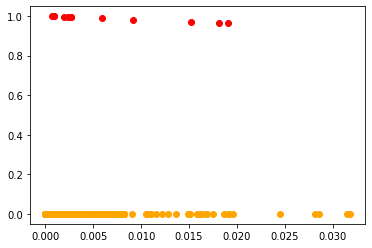

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import numpy as np

fig = plt.figure()
ax = plt.axes()

colors = ['red', 'orange', 'blue', 'purple']

ax.scatter(scores_p, weights_p, color = colors[0])
ax.scatter(scores_n, weights_n, color = colors[1])


In [16]:
import pytrec_eval
from statistics import mean
import scipy.stats as stats
from collections import defaultdict
VALIDATION_METRIC = 'recip_rank' 

qrel_file = f"../msmarco/qrels.train.tsv"

qrels = defaultdict(dict)
with open(qrel_file) as f:
    for line in f:
        try:
            qid, _, did, rel = line.strip().split("\t")
        except:
            qid, _, did, rel = line.strip().split(" ")
        if int(rel) > 0:
            qrels[qid][did] = int(rel)

trec_eval = pytrec_eval.RelevanceEvaluator(qrels, {VALIDATION_METRIC})

In [19]:
metrics_kl_train = []
for n in range(1000, 101000, 1000):
    run = defaultdict(dict)
    with open(f"qualitative/output_train_multipos_colbert_kldiv_iter{n}.tsv") as f:
        for line in f:
            qid,did,score = line.strip().split("\t")
            run[qid][did] = float(score)
    eval_run = trec_eval.evaluate(run)
    metrics_kl_train.append(np.mean([eval_run[x]['recip_rank'] for x in eval_run]))



metrics_klfr_train = []
for n in range(1000, 101000, 1000):
    run = defaultdict(dict)
    with open(f"qualitative/output_train_multipos_colbert_klfr-gamma5.0_iter{n}.tsv") as f:
        for line in f:
            qid,did,score = line.strip().split("\t")
            run[qid][did] = float(score)

    eval_run = trec_eval.evaluate(run)
    metrics_klfr_train.append(np.mean([eval_run[x]['recip_rank'] for x in eval_run]))


In [20]:
qrel_file = f"../msmarco/trec_qrels.txt"

qrels = defaultdict(dict)
with open(qrel_file) as f:
    for line in f:
        try:
            qid, _, did, rel = line.strip().split("\t")
        except:
            qid, _, did, rel = line.strip().split(" ")
        if int(rel) > 0:
            qrels[qid][did] = int(rel)
VALIDATION_METRIC = 'ndcg_cut_10' 
trec_eval = pytrec_eval.RelevanceEvaluator(qrels, {VALIDATION_METRIC})

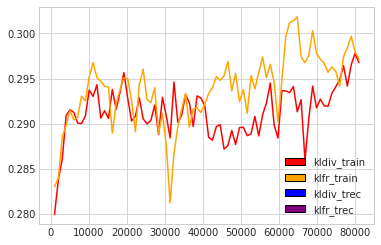

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.style.use('seaborn-whitegrid')
import numpy as np

fig = plt.figure()
ax = plt.axes()

colors = ['red', 'orange', 'blue', 'purple']
rlim = 80
x = np.linspace(1000, 1000 + rlim * 1000, rlim)
ax.plot(x, metrics_kl_train[:rlim], color = colors[0])
ax.plot(x, metrics_klfr_train[:rlim], color = colors[1])


handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in colors]
labels= ["kldiv_train","klfr_train","kldiv_trec","klfr_trec"]
plt.legend(handles, labels)

# Performance on easy & hard cases

In [4]:
from collections import defaultdict
top_k = 10
run_klfr = defaultdict(dict)
with open("results/output_dev_colbert_distill_splade_iter100k_kldiv5_focal_gamma5.0-alpha1.5_1e-5.tsv") as f:
    for line in f:
        qid, did, score = line.split("\t")
        run_klfr[qid][did] = float(score)

top_run_klfr = defaultdict(dict)
top_k = 10
for q in run_klfr:
    docs = sorted(run_klfr[q].items(), key=lambda x: -x[1])
    for item in docs[:top_k]:
        top_run_klfr[q][item[0]] = item[1]

run_teacher = defaultdict(dict)

with open("../msmarco/output_dev_teacher.tsv") as f, open("../msmarco/wentai_splade_dev_top100.tsv") as f2:
    for line in f:
        qid, did, score = line.split("\t")
        line2 = f2.readline()
        _, did, _, _ = line2.split("\t")
        run_teacher[qid][did] = float(score)

top_run_teacher = defaultdict(dict)
top_k = 10
for q in run_teacher:
    docs = sorted(run_teacher[q].items(), key=lambda x: -x[1])
    for item in docs[:top_k]:
        top_run_teacher[q][item[0]] = item[1]


run_kldiv = defaultdict(dict)
with open("results/output_dev_colbert_distill_splade_iter130k_kldiv5_0.0_1e-5.tsv") as f:
    for line in f:
        qid, did, score = line.split("\t")
        run_kldiv[qid][did] = float(score)

top_run_kldiv = defaultdict(dict)
top_k = 10
for q in run_kldiv:
    docs = sorted(run_kldiv[q].items(), key=lambda x: -x[1])
    for item in docs[:top_k]:
        top_run_kldiv[q][item[0]] = item[1]


In [61]:
import pytrec_eval
from statistics import mean
import scipy.stats as stats
from collections import defaultdict
VALIDATION_METRIC = 'recip_rank' 

qrel_file = f"../msmarco/qrels.dev.tsv"

qrels = defaultdict(dict)
with open(qrel_file) as f:
    for line in f:
        try:
            qid, _, did, rel = line.strip().split("\t")
        except:
            qid, _, did, rel = line.strip().split(" ")
        if int(rel) > 0:
            qrels[qid][did] = int(rel)

trec_eval = pytrec_eval.RelevanceEvaluator(qrels, {VALIDATION_METRIC})
eval_scores_teacher = trec_eval.evaluate(top_run_teacher)
eval_scores_kldiv = trec_eval.evaluate(top_run_kldiv)
eval_scores_klfr = trec_eval.evaluate(top_run_klfr)

In [62]:
import numpy as np
np.mean([eval_scores_klfr[x]['recip_rank'] for x in eval_scores_klfr]), np.mean([eval_scores_kldiv[x]['recip_rank'] for x in eval_scores_kldiv])

(0.41202854595532634, 0.40383810160640654)

In [71]:
left = 0
step = 0.05
bin_n = [0] * int(1/step)
kldiv_n = [0] * int(1/step)
kldiv_margin = [0] * int(1/step)
klfr_n = [0] * int(1/step)
klfr_margin = [0] * int(1/step)
i = 0

while left < 1:
    for q in eval_scores_kldiv:
        if eval_scores_teacher[q]['recip_rank'] >= left and eval_scores_teacher[q]['recip_rank'] <= left + step:
            bin_n[i] += 1
            kldiv_margin[i] += eval_scores_kldiv[q]['recip_rank'] - eval_scores_teacher[q]['recip_rank']
            klfr_margin[i] += eval_scores_klfr[q]['recip_rank'] - eval_scores_teacher[q]['recip_rank']
            
            if eval_scores_kldiv[q]['recip_rank'] >= eval_scores_teacher[q]['recip_rank']:
                kldiv_n[i] += 1
            if eval_scores_klfr[q]['recip_rank'] >= eval_scores_teacher[q]['recip_rank']:
                klfr_n[i] += 1
    left += step
    i += 1

In [69]:
kldiv_p = [x/y if y >0 else 0 for x,y in zip(kldiv_n, bin_n)]
klfr_p = [x/y if y >0 else 0 for x,y in zip(klfr_n, bin_n)]
kldiv_m = [x/y if y >0 else 0 for x,y in zip(kldiv_margin, bin_n)]
klfr_m = [x/y if y >0 else 0 for x,y in zip(klfr_margin, bin_n)]

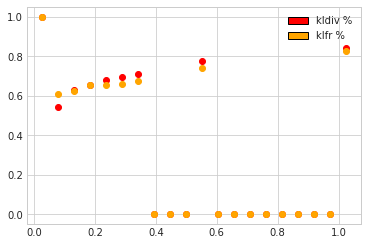

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.style.use('seaborn-whitegrid')
import numpy as np

fig = plt.figure()
ax = plt.axes()

colors = ['red', 'orange']

x = np.linspace(0.025, 1.025, 20)
ax.scatter(x, kldiv_p, color = colors[0])
ax.scatter(x, klfr_p, color = colors[1])

handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in colors[:2]]
labels= ["kldiv %","klfr %"]
plt.legend(handles, labels)

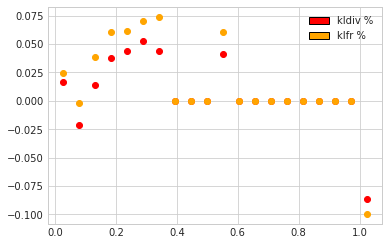

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.style.use('seaborn-whitegrid')
import numpy as np

fig = plt.figure()
ax = plt.axes()

colors = ['red', 'orange']

x = np.linspace(0.025, 1.025, 20)
ax.scatter(x, kldiv_m, color = colors[0])
ax.scatter(x, klfr_m, color = colors[1])

handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in colors[:2]]
labels= ["kldiv %","klfr %"]

plt.legend(handles, labels)

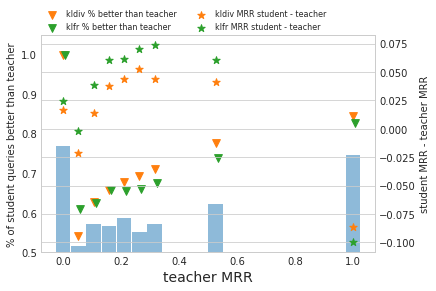

In [135]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.style.use('seaborn-whitegrid')
import numpy as np

fig = plt.figure()
ax = plt.axes()

colors = ['tab:orange', 'tab:green','tab:blue']
size = 60
scatters = []
bias = 0.007
x = np.linspace(0.0, 1.0, 20)
none_label = [i > 0 for i in bin_n]
x_m = [i for i,m in zip(x, none_label) if m]
kldiv_p_m = [i for i,m in zip(kldiv_p, none_label) if m]
klfr_p_m = [i for i,m in zip(klfr_p, none_label) if m]
scatters.append(ax.scatter(x_m, kldiv_p_m, color = colors[0], marker = "v",s = size))
scatters.append(ax.scatter([i + bias for i in x_m], klfr_p_m, color = colors[1], marker = "v", s = size))
ax.bar(x, [x/sum(bin_n) + 0.5 for x in bin_n], width=0.05, color = colors[2], alpha = 0.5)
ax.set_ylim(0.5, 1.05)

ax2=ax.twinx()

kldiv_m_m = [i for i,m in zip(kldiv_m, none_label) if m]
klfr_m_m = [i for i,m in zip(klfr_m, none_label) if m]

scatters.append(ax2.scatter(x_m, kldiv_m_m, color = colors[0], marker = "*",s = size))
scatters.append(ax2.scatter(x_m, klfr_m_m, color = colors[1], marker = "*",s = size))

plt.legend(scatters,
           ('kldiv % better than teacher', 'klfr % better than teacher', 'kldiv MRR student - teacher', 'klfr MRR student - teacher'),
           scatterpoints=1,
           loc=[0,1],
           ncol=2,
           fontsize=8)

ax.set_xlabel("teacher MRR", fontsize = 14)
ax.set_ylabel("% of student queries better than teacher")
ax2.set_ylabel("student MRR - teacher MRR")
ax.grid(False)

In [114]:
handles, labels = scatters[0].legend_elements()

/home/ec2-user/.local/lib/python3.9/site-packages/matplotlib/collections.py:1098: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


### Convergence

In [10]:
import pandas as pd
eval=pd.read_csv("training_with_sentence_transformers/output/colbert_splade_distill_num1_kldiv_default_alpha0.2_denoiseFalse_num20_kldiv5-lr1e-05-batch_size_8x4-2022-11-25/SubDevEvaluator_train-eval_results_copy.csv")
window=500
eval_ma = eval.rolling(window).median().dropna()
eval_ma

,epoch,steps,MAP,MRR@10
499,100199.0,25050.0,0.322720,0.306384
500,100599.0,25150.0,0.322712,0.306362
501,100999.0,25250.0,0.322712,0.306362
502,101399.0,25350.0,0.322712,0.306362
503,101799.0,25450.0,0.322712,0.306362
...,...,...,...,...
1495,498599.0,124650.0,0.321107,0.304309
1496,498999.0,124750.0,0.321124,0.304327
1497,499399.0,124850.0,0.321107,0.304309
1498,499799.0,124950.0,0.321124,0.304327


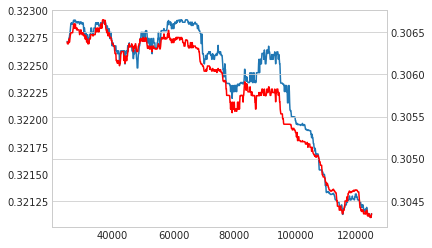

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

x=eval_ma.steps

plt.style.use('seaborn-whitegrid')
import numpy as np

fig = plt.figure()
ax = plt.axes()

colors = ['tab:orange', 'tab:green','tab:blue']


ax.plot(x, eval_ma.MAP)

ax2=ax.twinx()
ax2.plot(x, eval_ma['MRR@10'], color='red')


ax.grid(False)

# old

In [2]:
qrel_file = f"../msmarco/qrels.dev.tsv"

qrels = defaultdict(dict)
with open(qrel_file) as f:
    for line in f:
        try:
            qid, _, did, rel = line.strip().split("\t")
        except:
            qid, _, did, rel = line.strip().split(" ")
        if int(rel) > 0:
            qrels[qid][did] = int(rel)


teacher_run = defaultdict(dict)

with open(f"../msmarco/output_dev_teacher.tsv") as f1, open(f"../msmarco/wentai_splade_dev_top100.tsv") as f2:  # f"../msmarco/splade-remove/test{yr}.remove60.1000"  f"../msmarco/yifan_bm25_top1000.psg.20{yr}.trec.trec"
    for line in f1:
        line2 = f2.readline()
        qid, _, score = line.strip().split("\t")
        _, did, *_ = line2.strip().split("\t")
        teacher_run[qid][did] = float(score)
            

In [3]:
import pytrec_eval
from statistics import mean
import scipy.stats as stats
from collections import defaultdict
VALIDATION_METRIC = 'recip_rank' 

top_run = defaultdict(dict)
top_k = 10
for q in teacher_run:
    docs = sorted(teacher_run[q].items(), key=lambda x: -x[1])
    for item in docs[:top_k]:
        top_run[q][item[0]] = item[1]

trec_eval = pytrec_eval.RelevanceEvaluator(qrels, {VALIDATION_METRIC})
eval_scores_teacher = trec_eval.evaluate(top_run)

In [4]:
klrun = defaultdict(dict)

with open('results/output_dev_colbert_distill_splade_iter130k_kldiv5_0.0_1e-5.tsv') as f:
    for line in f:
        qid, did, score = line.strip().split("\t")
        klrun[qid][did] = float(score)

top_klrun = defaultdict(dict)
top_k = 10
for q in klrun:
    docs = sorted(klrun[q].items(), key=lambda x: -x[1])
    for item in docs[:top_k]:
        top_klrun[q][item[0]] = item[1]


eval_scores_kl = trec_eval.evaluate(top_klrun)

In [9]:
teacher_bad = []
kl_bad = []
for q in eval_scores_teacher:
    if eval_scores_teacher[q][VALIDATION_METRIC] < 0.2:
        teacher_bad.append(eval_scores_teacher[q][VALIDATION_METRIC])
        kl_bad.append(eval_scores_kl[q][VALIDATION_METRIC])

print(np.mean(teacher_bad), np.mean(kl_bad))

0.037014463549323064 0.05553229385175275


In [10]:
klrun_diff = {"pos": defaultdict(dict), "neg": defaultdict(dict)}

for q in top_klrun:
    for d in top_klrun[q]:
        if d in qrels[q] and qrels[q][d] > 0:
            klrun_diff['pos'][q][d] = top_klrun[q][d]
        else:
            klrun_diff['neg'][q][d] = top_klrun[q][d]

teacherrun_diff = {"pos": defaultdict(dict), "neg": defaultdict(dict)} 
for q in top_run:
    for d in top_run[q]:
        if d in qrels[q] and qrels[q][d] > 0:
            teacherrun_diff['pos'][q][d] = float(top_run[q][d])
        else:
            teacherrun_diff['neg'][q][d] = float(top_run[q][d])

In [11]:
kldiff = []
teacherdiff = []
for q in klrun_diff['pos']:
    pos_exp = np.exp(list(klrun_diff['pos'][q].values()))
    neg_exp = np.exp(list(klrun_diff['neg'][q].values()))
    kldiff.append(np.sum(pos_exp) / (np.sum(pos_exp) + np.sum(neg_exp)))

    pos_exp = np.exp(list(teacherrun_diff['pos'][q].values()))
    neg_exp = np.exp(list(teacherrun_diff['neg'][q].values()))
    teacherdiff.append(np.sum(pos_exp) / (np.sum(pos_exp) + np.sum(neg_exp)))



In [14]:
klfrrun = defaultdict(dict)

with open('results/output_dev_colbert_distill_splade_iter100k_kldiv5_focal_gamma5.0_1e-5.tsv') as f:
    for line in f:
        qid, did, score = line.strip().split("\t")
        klfrrun[qid][did] = float(score)

top_klfrrun = defaultdict(dict)
top_k = 10
for q in klfrrun:
    docs = sorted(klfrrun[q].items(), key=lambda x: -x[1])
    for item in docs[:top_k]:
        top_klfrrun[q][item[0]] = item[1]


eval_scores_klfr = trec_eval.evaluate(top_klfrrun)

In [16]:
teacher_bad = []
kl_bad = []
klfr_bad = []
for q in eval_scores_teacher:
    if eval_scores_teacher[q][VALIDATION_METRIC] < 0.2:
        teacher_bad.append(eval_scores_teacher[q][VALIDATION_METRIC])
        kl_bad.append(eval_scores_kl[q][VALIDATION_METRIC])
        klfr_bad.append(eval_scores_klfr[q][VALIDATION_METRIC])
print(np.mean(teacher_bad), np.mean(kl_bad), np.mean(klfr_bad))

0.037014463549323064 0.05553229385175275 0.06716521040142268


In [17]:
klfrrun_diff = {"pos": defaultdict(dict), "neg": defaultdict(dict)}

for q in top_klfrrun:
    for d in top_klfrrun[q]:
        if d in qrels[q] and qrels[q][d] > 0:
            klfrrun_diff['pos'][q][d] = top_klfrrun[q][d]
        else:
            klfrrun_diff['neg'][q][d] = top_klfrrun[q][d]
klfrdiff = []

for q in klfrrun_diff['pos']:
    pos_exp = np.exp(list(klfrrun_diff['pos'][q].values()))
    neg_exp = np.exp(list(klfrrun_diff['neg'][q].values()))
    klfrdiff.append(np.sum(pos_exp) / (np.sum(pos_exp) + np.sum(neg_exp)))

print(pd.Series(klfrdiff).describe())

count    4947.000000
mean        0.280264
std         0.253634
min         0.000162
25%         0.096969
50%         0.177742
75%         0.382539
max         0.999977
dtype: float64


In [22]:
klfrwrun = defaultdict(dict)

with open('results/output_dev_colbert_distill_splade_iter100k_kldiv5_focal_gamma5.0-alpha1.5_1e-5.tsv') as f:
#with open('results/output_19_colbert_distill_splade_iter100k_kldiv_focal_gamma5.0_1.5_1e-5.tsv') as f:
    for line in f:
        qid, did, score = line.strip().split("\t")
        klfrwrun[qid][did] = float(score)
        

top_klfrwrun = defaultdict(dict)
top_k = 10
for q in klfrwrun:
    docs = sorted(klfrwrun[q].items(), key=lambda x: -x[1])
    for item in docs[:top_k]:
        top_klfrwrun[q][item[0]] = item[1]


eval_scores_klfrw = trec_eval.evaluate(top_klfrwrun)

In [24]:
teacher_bad = []
kl_bad = []
klfr_bad = []
klfrw_bad = []
for q in eval_scores_teacher:
    if eval_scores_teacher[q][VALIDATION_METRIC] < 0.2:
        teacher_bad.append(eval_scores_teacher[q][VALIDATION_METRIC])
        kl_bad.append(eval_scores_kl[q][VALIDATION_METRIC])
        klfr_bad.append(eval_scores_klfr[q][VALIDATION_METRIC])
        klfrw_bad.append(eval_scores_klfrw[q][VALIDATION_METRIC])
print(np.mean(teacher_bad), np.mean(kl_bad), np.mean(klfr_bad), np.mean(klfrw_bad))

0.037014463549323064 0.05553229385175275 0.06716521040142268 0.06815183698638433


In [87]:
klfrwrun_diff = {"pos": defaultdict(dict), "neg": defaultdict(dict)}

for q in top_klfrwrun:
    for d in top_klfrwrun[q]:
        if d in qrels[q] and qrels[q][d] > 0:
            klfrwrun_diff['pos'][q][d] = top_klfrwrun[q][d]
        else:
            klfrwrun_diff['neg'][q][d] = top_klfrwrun[q][d]
klfrwdiff = []

for q in klfrwrun_diff['pos']:
    pos_exp = np.exp(list(klfrwrun_diff['pos'][q].values()))
    neg_exp = np.exp(list(klfrwrun_diff['neg'][q].values()))
    klfrwdiff.append(np.sum(pos_exp) / (np.sum(pos_exp) + np.sum(neg_exp)))

print(pd.Series(klfrwdiff).describe())

count    4132.000000
mean        0.374978
std         0.265155
min         0.000080
25%         0.179706
50%         0.282805
75%         0.517356
max         0.999982
dtype: float64


In [25]:
# check entropy between positive cases
# entropy merely changed

In [26]:
import pytrec_eval
from statistics import mean
import scipy.stats as stats
from collections import defaultdict
VALIDATION_METRIC = 'ndcg_cut_10' 

In [41]:
klposrun = defaultdict(list)
klfrposrun = defaultdict(list)
for yr in [19,20]:
    qrel_file = f"../msmarco/20{yr}qrels-pass.txt"

    qrels = defaultdict(dict)
    with open(qrel_file) as f:
        for line in f:
            try:
                qid, _, did, rel = line.strip().split("\t")
            except:
                qid, _, did, rel = line.strip().split(" ")
            if int(rel) > 0:
                qrels[qid][did] = int(rel)



    with open(f'results/output_{yr}_colbert_distill_splade_iter130k_kldiv5_0.0_1e-5.tsv') as f:
        for line in f:
            qid, did, score = line.strip().split("\t")
            if did in qrels[qid] and qrels[qid][did] == 3:
                klposrun[qid].append(float(score))

   
    

    with open(f'results/output_{yr}_colbert_distill_splade_iter100k_kldiv_focal_gamma5.0_1e-5.tsv') as f:
        for line in f:
            qid, did, score = line.strip().split("\t")
            if did in qrels[qid] and qrels[qid][did] == 3:
                klfrposrun[qid].append(float(score))

In [42]:
from scipy.stats import entropy
klentropy = []
klfrentropy = []
for q in klposrun:
    klentropy.append(entropy(klposrun[q], base=2))
    klfrentropy.append(entropy(klfrposrun[q], base=2))

In [43]:
np.mean(klentropy), np.mean(klfrentropy)

(2.7367651567249944, 2.736495506915399)

In [77]:
kldiff = []
klfrdiff = []
klfrwdiff = []
for q in teacher_eval_scores:
    if teacher_eval_scores[q]['ndcg_cut_10'] < 2:

        pos_mean = np.mean(list(klrun['pos'][q].values()))
        neg_mean = np.mean(list(klrun['neg'][q].values()))
        kldiff.append(pos_mean - neg_mean)

        pos_mean = np.mean(list(klfrrun['pos'][q].values()))
        neg_mean = np.mean(list(klfrrun['neg'][q].values()))
        klfrdiff.append(pos_mean - neg_mean)

    
        pos_mean = np.mean(list(klfrwrun['pos'][q].values()))
        neg_mean = np.mean(list(klfrwrun['neg'][q].values()))
        klfrwdiff.append(pos_mean - neg_mean)

print(np.mean(kldiff), np.mean(klfrdiff),np.mean(klfrwdiff))


nan nan nan


/home/ec2-user/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ec2-user/.local/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [60]:
print(np.mean(kldiff), np.mean(klfrdiff),np.mean(klfrwdiff))

2.3647328517770685 2.855839404078327 3.50755143356493


In [62]:
# Teacher vs Student NDCG
kldiff = []
klfrdiff = []
klfrwdiff = []
qrels = defaultdict(dict)
teacherrun = defaultdict(dict)
klrun = defaultdict(dict)
klfrrun = defaultdict(dict)
klfrwrun = defaultdict(dict)

for yr in [19,20]:
    qrel_file = f"../msmarco/20{yr}qrels-pass.txt" 
    with open(qrel_file) as f:
        for line in f:
            try:
                qid, _, did, rel = line.strip().split("\t")
            except:
                qid, _, did, rel = line.strip().split(" ")
            if int(rel) > 0:
                qrels[qid][did] = int(rel)


    with open(f"../msmarco/output_20{yr}_teacher.tsv") as f1, open(f"../msmarco/wentai_splade_20{yr}.trec") as f2:  # f"../msmarco/splade-remove/test{yr}.remove60.1000"  f"../msmarco/yifan_bm25_top1000.psg.20{yr}.trec.trec"
        for line in f1:
            line2 = f2.readline()
            qid, _, score = line.strip().split("\t")
            _, _, did, *_ = line2.strip().split("\t")
            teacherrun[qid][did] = float(score)


    with open(f'results/output_{yr}_colbert_distill_splade_iter130k_kldiv5_0.0_1e-5.tsv') as f:
        for line in f:
            qid, did, score = line.strip().split("\t")
            klrun[qid][did] = float(score)

    with open(f'results/output_{yr}_colbert_distill_splade_iter100k_kldiv_focal_gamma5.0_1e-5.tsv') as f:
        for line in f:
            qid, did, score = line.strip().split("\t")
            klfrrun[qid][did] = float(score)
    
    with open(f'results/output_{yr}_colbert_distill_splade_iter100k_kldiv_focal_gamma5.0_1.5_1e-5.tsv') as f:
        for line in f:
            qid, did, score = line.strip().split("\t")
            klfrwrun[qid][did] = float(score)

In [67]:
trec_eval = pytrec_eval.RelevanceEvaluator(qrels, {VALIDATION_METRIC})
teacher_scores = trec_eval.evaluate(teacherrun)
kl_scores = trec_eval.evaluate(klrun)
klfr_scores = trec_eval.evaluate(klfrrun)
klfrw_scores = trec_eval.evaluate(klfrwrun)

In [68]:
for q in  teacher_scores:
    if teacher_scores[q]['ndcg_cut_10'] < 0.5:
        print(teacher_scores[q]['ndcg_cut_10'], kl_scores[q]['ndcg_cut_10'], klfr_scores[q]['ndcg_cut_10'], klfrw_scores[q]['ndcg_cut_10'])

0.3863207846351753 0.43265160936564095 0.3233688044978225 0.12686754312833895
0.1959706126051752 0.21716506505057828 0.28800536665698434 0.3055416739546688
0.48184494178556875 0.1926157378190483 0.3343417383575265 0.10183032621685657
0.46582309483828654 0.4495923615080624 0.5905815128977229 0.6208702696513756
0.4512570687637423 0.5522384239725907 0.45060485404037265 0.568073551751966
0.41690740278367383 0.520201777869074 0.513216899917906 0.46408383269648545
0.34968969883181067 0.17449637174907276 0.25455244536891414 0.2675679548711949
0.1884441521277154 0.2399208948023808 0.34051969290975714 0.3280622976814645
0.07257302962625321 0.07668368701422457 0.0 0.0
0.29070438396105863 0.28567767481247575 0.32134194606983163 0.3250227623767359


In [3]:
from collections import defaultdict
qrel_file = f"../msmarco/qrels.dev.tsv"

qrels = defaultdict(dict)
with open(qrel_file) as f:
    for line in f:
        try:
            qid, _, did, rel = line.strip().split("\t")
        except:
            qid, _, did, rel = line.strip().split(" ")
        if int(rel) > 0:
            qrels[qid][did] = int(rel)


teacher_run = defaultdict(dict)

with open(f"output_dev_teacher.tsv") as f1, open(f"../msmarco/wentai_splade_dev_top100.tsv") as f2:  # f"../msmarco/splade-remove/test{yr}.remove60.1000"  f"../msmarco/yifan_bm25_top1000.psg.20{yr}.trec.trec"
    for line in f1:
        line2 = f2.readline()
        qid, _, score = line.strip().split("\t")
        _, did, *_ = line2.strip().split("\t")
        teacher_run[qid][did] = float(score)
            

In [4]:
import pytrec_eval

from statistics import mean
import scipy.stats as stats
from collections import defaultdict
VALIDATION_METRIC = 'recip_rank' 

top_run = defaultdict(dict)
top_k = 10
for q in teacher_run:
    docs = sorted(teacher_run[q].items(), key=lambda x: -x[1])
    for item in docs[:top_k]:
        top_run[q][item[0]] = item[1]

trec_eval = pytrec_eval.RelevanceEvaluator(qrels, {VALIDATION_METRIC})
eval_scores_teacher = trec_eval.evaluate(top_run)

In [6]:
mean([eval_scores_teacher[q]['recip_rank'] for q in eval_scores_teacher])

0.40665893482512394

In [10]:
from collections import defaultdict
qrels = defaultdict(dict)

with open("../msmarco/trec_qrels.txt") as f:
    for line in f:
        qid, _, did, rel = line.split(" ")
        qrels[qid][did] = int(rel)

fo = open("../msmarco/2019_2020_rel0_data.tsv", "w")

top100_run = defaultdict(dict)

with open("../msmarco/wentai_splade_2019.trec") as f:
    for line in f:
        qid, _, did, rank, _, _ = line.strip().split("\t")
        if int(rank) < 50:
            if did not in qrels[qid] or qrels[qid][did] == 0:
                top100_run[qid][did] = 1
with open("../msmarco/wentai_splade_2019_top1000.tsv") as f:
    for line in f:
        qid, did, _, _ = line.strip().split("\t")
        if qid in top100_run and did in top100_run[qid]:
            fo.write(line)


top100_run = defaultdict(dict)

with open("../msmarco/wentai_splade_2020.trec") as f:
    for line in f:
        qid, _, did, rank, _, _ = line.strip().split("\t")
        if int(rank) < 50:
            if did not in qrels[qid] or qrels[qid][did] == 0:
                top100_run[qid][did] = 1
with open("../msmarco/wentai_splade_2020_top1000.tsv") as f:
    for line in f:
        qid, did, _, _ = line.strip().split("\t")
        if qid in top100_run and did in top100_run[qid]:
            fo.write(line)

fo.close()